# MNIST Example

This demo is an adaption of our [first `MNIST` themed demo](mnist_example.ipynb), which computes saliency maps for the models' actual prediction.

Here, we only analyze one input sample, but compute saliency maps for all of the model's output neurons, one at a time.

# Imports

In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
%matplotlib inline  

import numpy as np
import imp
import time

import keras
import keras.backend
import keras.models

import innvestigate
import innvestigate.applications
import innvestigate.applications.mnist
import innvestigate.utils as iutils
import innvestigate.utils.visualizations as ivis


eutils = imp.load_source("utils", "../utils.py")
mnistutils = imp.load_source("utils_mnist", "../utils_mnist.py")

Using TensorFlow backend.


# Data
Then, the MNIST data is loaded in its entirety, formatted wrt to the specifications of the keras backend.

In [3]:
# Load data
channels_first = keras.backend.image_data_format() == "channels_first"
data = mnistutils.fetch_data(channels_first) #returns x_train, y_train, x_test, y_test as numpy.ndarray
num_classes = len(np.unique(data[1]))

# Test samples for illustrations
images = [(data[2][i].copy(), data[3][i]) for i in range(num_classes)]
label_to_class_name = [str(i) for i in range(num_classes)]

60000 train samples
10000 test samples


# Model
We have prepared a simple model configuration to play around with.

In [4]:
# The line below currently configures an already pretrained network, which saves some time.
modelname = 'pretrained_plos_long_relu'
activation_type = 'relu'
input_range = [-1, 1]
epochs = 0
batch_size = None
create_model_kwargs = {}

Now, preprocess the data wrt to the model's requirements, build the model and optionally train it for `epochs` epochs. 

In [5]:
# Preprocess data
data_preprocessed = (mnistutils.preprocess(data[0], input_range), data[1],
                     mnistutils.preprocess(data[2], input_range), data[3])


# Create & (optionally) train model
model, modelp = mnistutils.create_model(channels_first, modelname, **create_model_kwargs)
mnistutils.train_model(modelp, data_preprocessed, batch_size=batch_size, epochs=epochs)
model.set_weights(modelp.get_weights())

Test loss: 0.029667358092008135
Test accuracy: 0.9917


# Analysis

Here, we will restict the selection of methods to those analyzers where output neuron selectino is a supported feature.

In [6]:
# Determine analysis methods and properties
methods = [
    # NAME                    OPT.PARAMS               POSTPROC FXN                TITLE

    # Show input
    ("input",                 {},                       mnistutils.image,          "Input"),

    # Function
    ("gradient",              {},                       mnistutils.graymap,        "Gradient"),

    # Signal
    ("deconvnet",             {},                       mnistutils.bk_proj,        "Deconvnet"),
    ("guided_backprop",       {},                       mnistutils.bk_proj,        "Guided Backprop",),
    ("pattern.net",           {},                       mnistutils.bk_proj,        "PatternNet"),

    # Interaction
    ("lrp.z",                 {},                       mnistutils.heatmap,         "LRP-Z"),
    ("lrp.epsilon",           {"epsilon": 1},           mnistutils.heatmap,         "LRP-Epsilon"),
    ]

The main loop below will now instantiate the analyzer objects based on the loaded/trained model and the analyzers' parameterizations above and compute the analyses.

First, we pick an input image which will stay fixed for all methods. Then, we iterate over the model's output neurons instead of input images.

In [7]:
# Prepare input image
input_image_idx = 1
image, y = images[input_image_idx]

image = image[None, :, :, :]


# Create analyzers.
analyzers = []
print('Creating analyzer instances. ')
for method in methods:
    analyzer = innvestigate.create_analyzer(method[0],   # analysis method identifier
                                            model,       # model without softmax output
                                            neuron_selection_mode="index", #THIS LINE ENABLES OUTPUT NEURON SELECTION
                                            **method[1]) # optional analysis parameters
    # some analyzers require additional training. For those
    analyzer.fit(data_preprocessed[0],
                 pattern_type=activation_type,
                 batch_size=256, verbose=1)
    analyzers.append(analyzer)

    
print('Running analyses.')
# Apply analyzers to trained model.
analysis = np.zeros([10, len(analyzers), 28, 28, 3])
text = []
for i in range(10):
    print('Output Neuron {}: '.format(i), end='')
    t_start = time.time()
    
    # Predict label.
    x = mnistutils.preprocess(image, input_range)
    presm = model.predict_on_batch(x)[0] #forward pass without softmax
    prob = modelp.predict_on_batch(x)[0] #forward pass with softmax
    y_hat = prob.argmax()
    
    # Save prediction info:
    text.append(("%s" %label_to_class_name[y], # ground truth label
                 "%.2f" %presm[i],             # pre-softmax logits
                 "%.2f" %prob[i],              # probabilistic softmax output  
                 "%s" %label_to_class_name[i]  # predicted label
                ))
    
    for aidx, analyzer in enumerate(analyzers):
        
        is_input_analyzer = methods[aidx][0] == "input"
        # Analyze.
        a = analyzer.analyze(image if is_input_analyzer else x, i)
        
        # Postprocess.
        if not is_input_analyzer:
            a = mnistutils.postprocess(a)
        a = methods[aidx][2](a)
        analysis[i, aidx] = a[0]
    t_elapsed = time.time() - t_start
    print('{:.4f}s'.format(t_elapsed))

Creating analyzer instances. 
Epoch 1/1
235/235 [==============================] - 2s 8ms/step - loss: 4.0000 - broadcast_1_loss: 1.0000 - broadcast_2_loss: 1.0000 - broadcast_3_loss: 1.0000 - broadcast_4_loss: 1.0000
Running analyses.
Output Neuron 0: 2.2193s
Output Neuron 1: 0.0155s
Output Neuron 2: 0.0192s
Output Neuron 3: 0.0183s
Output Neuron 4: 0.0178s
Output Neuron 5: 0.0166s
Output Neuron 6: 0.0168s
Output Neuron 7: 0.0177s
Output Neuron 8: 0.0190s
Output Neuron 9: 0.0174s



Next, we visualize the analysis results.

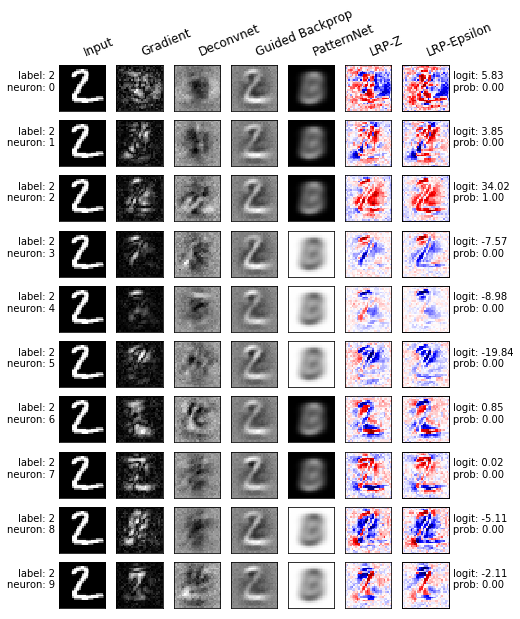

In [8]:
# Plot the analysis.
grid = [[analysis[i, j] for j in range(analysis.shape[1])]
        for i in range(analysis.shape[0])]
label, presm, prob, pred = zip(*text)
row_labels_left = [('label: {}'.format(label[i]),'neuron: {}'.format(pred[i])) for i in range(len(label))]
row_labels_right = [('logit: {}'.format(presm[i]),'prob: {}'.format(prob[i])) for i in range(len(label))]
col_labels = [''.join(method[3]) for method in methods]

eutils.plot_image_grid(grid, row_labels_left, row_labels_right, col_labels)

Each column shows the visualized results for different analyzers and each row shows the analyses wrt to the same input sample. To the left of each row, the ground truth label `label` and the selected output `neuron` are show. To the right, the model's probabilistic (softmax) output is shown for that neuron as `prob` and the logit output just before the terminating softmax layer as `logit`. Note that all analyses have been performed based on the logit output (layer).